ValueError: too many values to unpack (expected 3)

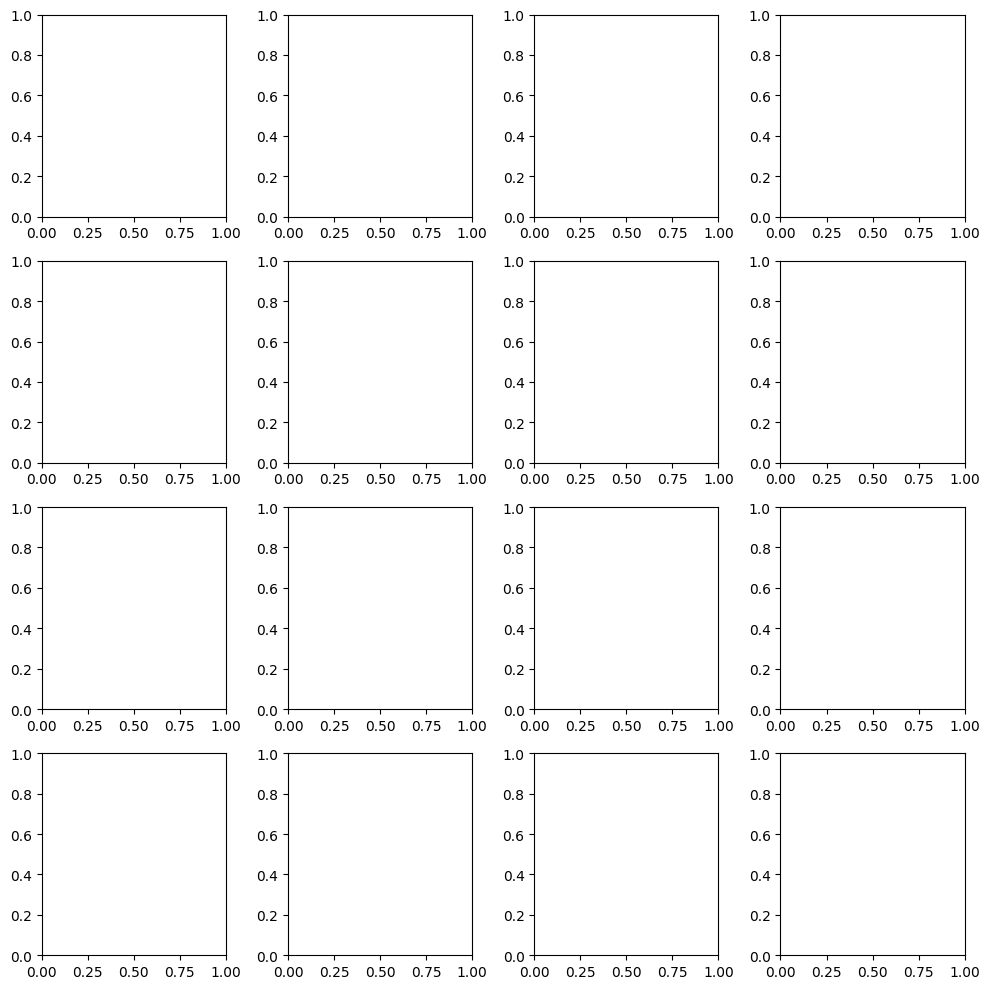

In [ ]:
import torch
from torch.utils.data import DataLoader
from datasets.clock import ClockConfig, ClockDataset
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMG_SIZE = 128
BATCH_SIZE = 64
data_size = 4096

data_config = ClockConfig(
    minute_hand_len=1,
    minute_hand_start=0.5,
    miute_hand_thickness=0.1,
    hour_hand_len=0.5,
    hour_hand_start=0,
    hour_hand_thickness=0.1
)

dataset = ClockDataset(len=data_size, img_size=IMG_SIZE, augment=False, config=data_config)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# visualize 16 images
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.tight_layout()
batch, labels2d, _ = next(iter(dataloader))
for i in range(16):
    img = batch[i].unsqueeze(0)
    label = labels2d[i].numpy()
    hour = label[0] * 12
    minute = label[1] * 60
    axs[i // 4, i % 4].imshow(img[0].squeeze(), cmap='gray')
    axs[i // 4, i % 4].set_title(f"{hour:.0f}h{minute:.0f}m")
    axs[i // 4, i % 4].axis('off')


# plt.show()

In [1]:
from models.encoders import TwoHeadConvEncoder, ConvSelfAttentionEncoder, ConvResEncoder, DeepConvResEncoder, WideConvResEncoder
from models.decoders import ResNetDecoder
import torch

torch.cuda.empty_cache()

LATENT_DIM = 2

model = ResNetDecoder(img_size=IMG_SIZE, latent_dim=2, conv_only_decoder=True).to(device)
model.eval()
dummy_input = torch.randn(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE).to(device)
dummy_input = torch.randn(BATCH_SIZE, LATENT_DIM).to(device)
y = model(dummy_input)
y.shape




NameError: name 'IMG_SIZE' is not defined

In [ ]:
from models.encoders import ConvMLPEncoder, DeepConvResEncoder, MLPEncoder, TwoHeadConvEncoder, ConvResEncoder, WideConvResEncoder
from torch import nn

cls = ConvMLPEncoder



# count params
print_model_parameters(ae)


Layer                                       Param Count
------------------------------------------------------------
conv.0.downsample1.0.bias                          1024
conv.0.downsample1.0.weight_orig                   9216
conv.0.downsample1.1.weight                        1024
conv.0.downsample1.1.bias                          1024
conv.0.downsample1.4.bias                          1024
conv.0.downsample1.4.weight_orig                9437184
conv.0.downsample1.5.weight                        1024
conv.0.downsample1.5.bias                          1024
conv.0.downsample2.0.bias                          1024
conv.0.downsample2.0.weight_orig                9437184
conv.0.downsample2.1.weight                        1024
conv.0.downsample2.1.bias                          1024
conv.0.downsample2.4.bias                          1024
conv.0.downsample2.4.weight_orig                9437184
conv.0.downsample2.5.weight                        1024
conv.0.downsample2.5.bias                  

: 

# Checkpoints

In [1]:
import os
from datasets.clock import ClockDataset, ClockConfig
import torch
from torch.utils.data import DataLoader
from config import MODELS_DIR

MODELS_DIR = 'saved_models'
LATENT_DIM = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model_and_dataset(
    img_size=128,
    batch_size=64,
    data_size=2048,
    latent_dim=2,
    postfix='',
    name='model',
    data_config=None,
    checkpoint=None
):
    """
    Load the model and dataset for inference.
    """
    # Load dataset
    dataset = ClockDataset(device=device, len=data_size, img_size=img_size, augment=False, config=data_config)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=device.type != 'cuda')

    # Load trained model
    model_file = f"{latent_dim}-i{img_size}{postfix}"
    
    if checkpoint is None:
      model_path = os.path.join(MODELS_DIR, name, model_file, f"final.pt")
    else:
      model_path = os.path.join(MODELS_DIR, name, model_file, f"{checkpoint}.pt")
    
    model = torch.jit.load(model_path).to(device)
    model.eval()
    
    return model, dataloader

data_config = ClockConfig(
    minute_hand_len=1,
    minute_hand_start=0.5,
    miute_hand_thickness=0.1,
    hour_hand_len=0.5,
    hour_hand_start=0,
    hour_hand_thickness=0.1
)

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
import typing

torch.cuda.empty_cache()

def get_outputs(model, dataloader):
  model.train()
  with torch.no_grad():
    for _, clean_imgs, label2d, label1d in dataloader:
      label2d = label2d.to(device)
      images = clean_imgs.to(device)
      label2d_unnormalized = (label2d * torch.tensor([12, 60]).to(device).float())
      label1d_unnormalized = (label1d * 60 * 12).to(device)
      pred = model.forward(images)

      for i in range(images.size(0)):
        yield images[i], pred[i], label1d_unnormalized[i], label2d_unnormalized[i]
  

model, dataloader = load_model_and_dataset(
    img_size=128,
    data_config=data_config,
    latent_dim=LATENT_DIM,
    name='ConvMLPEncoder',
    postfix='-d20',
)

# data_iter = get_outputs(model, dataloader)
img, pred, label1d, label2d = next(get_outputs(model, dataloader))

In [3]:
for i in get_outputs(model, dataloader):
  print(i[1])

tensor([0.6904], device='cuda:0')
tensor([0.2988], device='cuda:0')
tensor([0.8845], device='cuda:0')
tensor([0.5709], device='cuda:0')
tensor([0.1194], device='cuda:0')
tensor([0.7850], device='cuda:0')
tensor([0.3844], device='cuda:0')
tensor([0.8056], device='cuda:0')
tensor([0.6256], device='cuda:0')
tensor([0.1794], device='cuda:0')
tensor([0.8544], device='cuda:0')
tensor([0.3149], device='cuda:0')
tensor([0.1239], device='cuda:0')
tensor([0.7416], device='cuda:0')
tensor([0.3536], device='cuda:0')
tensor([0.8819], device='cuda:0')
tensor([0.5992], device='cuda:0')
tensor([0.1360], device='cuda:0')
tensor([0.8450], device='cuda:0')
tensor([0.3755], device='cuda:0')
tensor([0.4829], device='cuda:0')
tensor([0.6631], device='cuda:0')
tensor([0.2478], device='cuda:0')
tensor([0.8302], device='cuda:0')
tensor([0.5059], device='cuda:0')
tensor([0.1448], device='cuda:0')
tensor([0.7879], device='cuda:0')
tensor([0.3623], device='cuda:0')
tensor([0.8489], device='cuda:0')
tensor([0.6274

101it [00:00, 1396.06it/s]            


[array([497.05783], dtype=float32), array([215.14815], dtype=float32), array([636.83044], dtype=float32), array([411.05212], dtype=float32), array([85.96498], dtype=float32), array([565.18866], dtype=float32), array([276.74554], dtype=float32), array([580.02203], dtype=float32), array([450.4115], dtype=float32), array([129.14117], dtype=float32)]


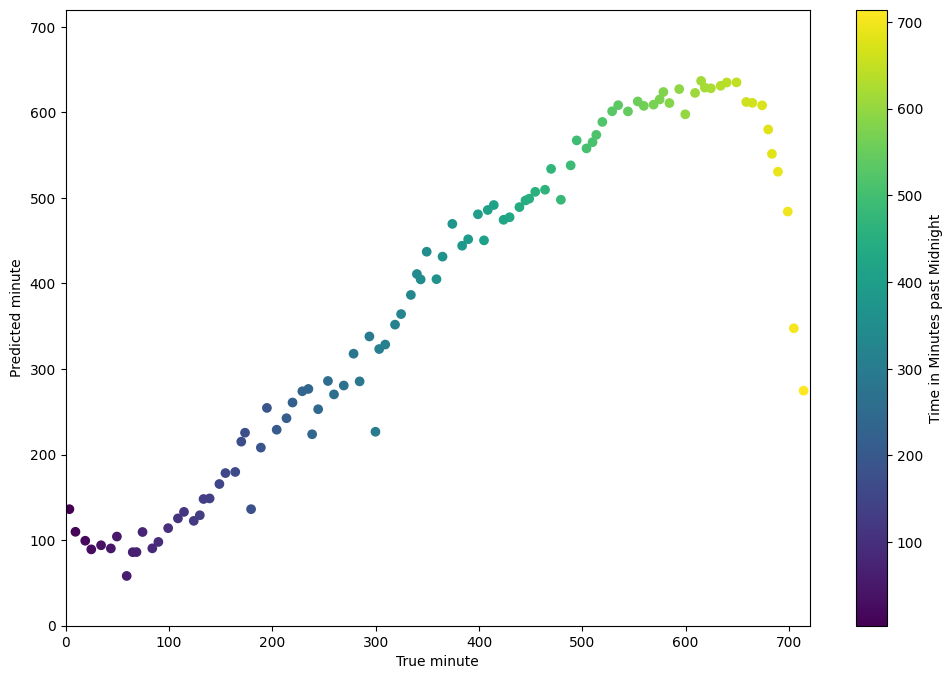

In [4]:
predicted_labels = []
labels1d = []
labels2d = []

for i, (img, pred, label1d, label2d) in enumerate(tqdm(get_outputs(model, dataloader), total=len(dataloader))):
    if i > 100:
        break
    pred_label = (pred*torch.tensor([12, 60]).to(device)).cpu().numpy() if LATENT_DIM == 2 else (pred*60*12).cpu().numpy()
    predicted_labels.append(pred_label)
    labels1d.append(label1d.cpu().numpy())
    labels2d.append(label2d.cpu().numpy())


if LATENT_DIM == 2:
  plt.figure(figsize=(12, 8))
  plt.scatter(labels2d[:, 0], labels2d[:, 1], c=labels1d, label='True Labels', s=3)
  plt.scatter(predicted_labels[:,0], predicted_labels[:,1], c=labels1d, label='Predicted Labels')
  plt.colorbar(label='Time in Minutes past Midnight')
  plt.xlabel('Hour')
  plt.ylabel('Minute')
  plt.legend()
if LATENT_DIM == 1:
  plt.figure(figsize=(12, 8))
  plt.scatter(labels1d, predicted_labels, c=labels1d, label='Predicted Labels')
  plt.colorbar(label='Time in Minutes past Midnight')
  plt.xlabel('True minute')
  plt.ylabel('Predicted minute')
  plt.xlim(0, 60*12)
  plt.ylim(0, 60*12)
  
print(predicted_labels[:10])

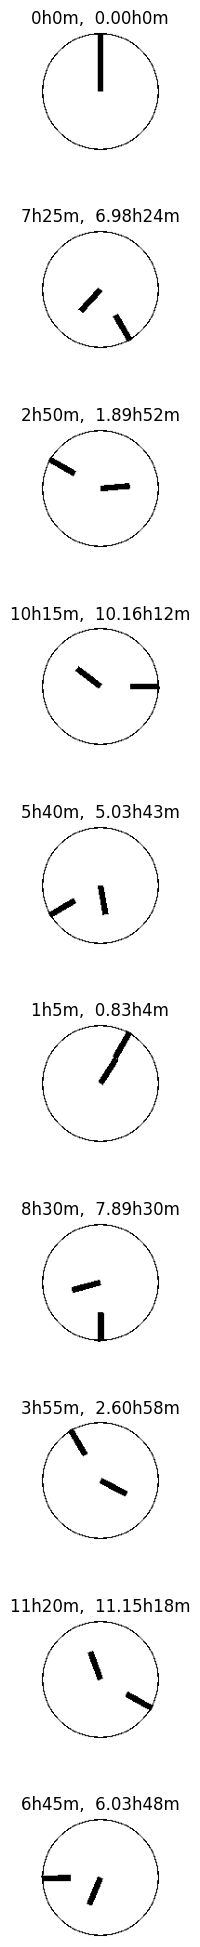

: 

In [ ]:
# Visualize the predictions
n=10
fig, axs = plt.subplots(n, 1, figsize=(2, 2*n))
fig.tight_layout()

for i in range(n):
  img = imgs[i].squeeze()
  label = labels2d[i]
  predicted_label = predicted_labels2d[i]
  
  axs[i].imshow(img, cmap='gray')
  axs[i].set_title(f"{label[0]:.0f}h{label[1]:.0f}m,  {predicted_label[0]:.2f}h{predicted_label[1]:.0f}m")
  axs[i].axis('off')
